<b>Исследование синхронизации нейроморфных сетей тесного мира.</b>

Участники:\
    Пеганов Никита\
    Диана Мустаева\
    Роман Головин

In [86]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from brian2 import *
from random import *
from collections import *

Составляем граф модели тесного мира.

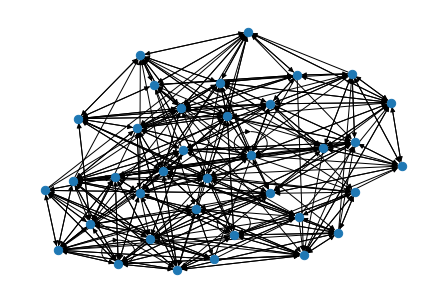

In [81]:
side = 6
sw = nx.navigable_small_world_graph(side, p=2, q=side//2, r=0.01)
options = {
    'node_size': 70,
    'width': 1,
}
nx.draw(sw, **options)

In [90]:
side = 20
n = side**2
sw = nx.navigable_small_world_graph(side, p=3, q=5, r=0.01, seed=5)

In [88]:
pairs = list(sw.edges)

In [89]:
G = defaultdict(set)
for edge in pairs:
    G[edge[0]].add(edge[1])

In [92]:
triangles = []
for edge in pairs:
    edge_start = edge[0]
    edge_finish = edge[1]
    for potential_vertex in G[edge_finish]:
        if edge_start in G[potential_vertex]:
            triangles.append((edge_start, edge_finish, potential_vertex))

In [ ]:
kuramoto_k = 0

INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


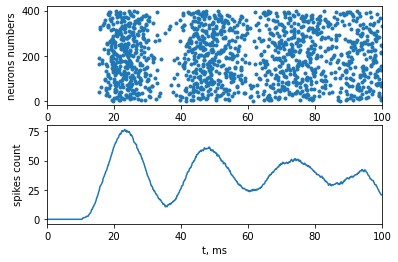

In [4]:
# константы
N = side ** 2
Vr = 10 * mV
theta = 20 * mV
tau = 20 * ms
delta = 2 * ms
taurefr = 2 * ms
duration = .1 * second
J = .1 * mV
muext = 25 * mV
sigmaext = 1 * mV

vertex_num = lambda vertex: vertex[0] * side + vertex[1]
eqs = """
      dV/dt = (-V+muext + sigmaext * sqrt(tau) * xi)/tau : volt
      """
group = NeuronGroup(N, eqs, threshold='V>theta',
                    reset='V=Vr', refractory=taurefr, method='euler')
group.V = Vr

# расстановка весов у синапсов
syn = Synapses(group, group, 'w : 1', on_pre='V += -J')
for edge in sw.edges:
    syn.connect(i=vertex_num(edge[0]), j=vertex_num(edge[1]))
    syn.w = '0.5'

M = SpikeMonitor(group)
LFP = PopulationRateMonitor(group)
net = Network(group, syn, M, LFP)
net.run(duration)
subplot(211)
plot(M.t/ms, M.i, '.')
xlim(0, duration/ms)
xlabel('t, ms')
ylabel('neurons numbers')
subplot(212)
plot(LFP.t/ms, LFP.smooth_rate(window='flat', width=10*ms)/Hz)
xlim(0, duration/ms)
xlabel('t, ms')
ylabel('spikes count')
show()

Нейроны синхронизировались.

Удаление нейрона

In [5]:
def delete_neuron(number):
    for i in list(syn.i):
        if syn.i[i] == number:
            syn.w[i] = 0

Определение степени синхронизации.

In [6]:
def find_min_max(count=4, start=20, dist=10):
    maxs = [0] * count
    maxs_j = [0] * count
    mins = [float('inf')] * count
    mins_j = [0] * count
    last_max_j, last_min_j = 0, 0
    for j in range(len(LFP.smooth_rate(window='flat', width=10*ms)/Hz)):
        elem = list(LFP.smooth_rate(window='flat', width=10*ms)/Hz)[j]
        for i in range(len(maxs)):
            if j - last_max_j > dist and elem > maxs[i]:
                maxs[i + 1:] = maxs[i:-1].copy()
                maxs_j[i + 1:] = maxs_j[i:-1].copy()
                maxs[i] = elem
                maxs_j[i] = j
                last_max_j = j
                break
        for i in range(len(mins)):
            if list(LFP.t/ms)[j] > start and j - last_min_j > dist and elem < mins[i]:
                mins[i + 1:] = mins[i:-1].copy()
                mins_j[i + 1:] = mins_j[i:-1].copy()
                mins[i] = elem
                mins_j[i] = j
                last_min_j = j
                break
    return maxs_j, mins_j

In [7]:
def find_sum(lis_max, lis_min):
    return (lis_min[0] - lis_max[0])**2 + (lis_min[1] - lis_max[1])**2 + (lis_min[2] - lis_max[2])**2 + (lis_min[3] - lis_max[3])**2 

Поочередно удаляем нейроны и считаем степень синхронизации полученной сети.

In [8]:
remain_neurons = list(range(side ** 2))
sync = []
prev = copy(LFP.smooth_rate(window='flat', width=10.1*ms)/Hz)
print(len(prev))
for i in range(30):
    group = NeuronGroup(N, eqs, threshold='V>theta',
                    reset='V=Vr', refractory=taurefr, method='euler')
    group.V = Vr
    syn = Synapses(group, group, 'w : 1', on_pre='V += -J')
    for edge in sw.edges:
        syn.connect(i=vertex_num(edge[0]), j=vertex_num(edge[1]))
        syn.w = '0.5'

    M = SpikeMonitor(group)
    LFP = PopulationRateMonitor(group)
    net = Network(group, syn, M, LFP)
    for j in range(10):
        deleting_neuron = choice(remain_neurons)
        delete_neuron(deleting_neuron)
        remain_neurons.remove(deleting_neuron)
    net.run(duration)
    
    new_one = LFP.smooth_rate(window='flat', width=10.1*ms)/Hz
    # print(any([new_one[k] - prev[k] for k in range(min(len(new_one), len(prev))]))
    # prev = copy(new_one)
    print(len(new_one))
    
    max_index, min_index = find_min_max(4)
    max_item = []
    min_item = []
    max_list = []
    min_list = []
    for i in range(len(max_index)):
        max_item.append(LFP.t[max_index[i]])
        max_list.append(max_item)
        min_item.append(LFP.t[min_index[i]])
        min_list.append(min_item)
    sync.append(find_sum(max_item, min_item))
subplot(212)
plot(sync)
ylabel('sync')
xlabel('p')

1000
1000
1000
1000
1000
1000


KeyboardInterrupt: 

Вывод: удаление нейронов не влияет на синхронизацию.